# David Stanko
# Climate Project - Complete Analysis Notebook

## Introduction

I analyzed time series data containing the sea surface temperature, wind speed, and wave height over eighty years from the seven major ocean basins. My goal was to determine a climate trend over time using one or more of those features. I also answered the following additional analysis questions: In the North Pacific and South Pacific ocean basins, what is the relationship between sea surface temperature and wave height? What is the relationship between sea surface temperature and wind? Which feature is more important for predicting the sea surface temperature?

## Data Source

The data was taken from the [ERA5 Reanalysis Product](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview). The ERA5 data was produced by the European Center for Medium-Range Weather Forecasting (ECMWF). There is a separate dataset for each ocean basin. Each of those datasets contains features for time, wave height, wind speed, sea surface temperature, latitude, and longitude.. The time ranges from 01/01/1940 to 02/29/2024. The wave height is measured in meters, the wind speed is measured in meters per second, and the sea surface temperature is measured in Kelvins.

In [597]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Data cleaning

### Load the data and inspect its contents

In [598]:
arctic_ocean = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/arctic.csv")
indian_ocean = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/indian.csv")
north_atlantic_ocean = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/north_atlantic.csv")
north_pacific = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/north_pacific.csv")
south_atlantic_ocean = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/south_atlantic.csv")
south_pacific = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/south_pacific.csv")
southern_ocean = pd.read_csv("https://raw.githubusercontent.com/galenegan/DATA-3320/main/climate/southern.csv")

In [599]:
arctic_ocean.head()

,sst,u10,hsig,time,latitude,longitude
0,271.45996,0.009604,NaN,1940-01-01 12:00:00,70.0,-140.1
1,271.45996,6.529120,NaN,1940-01-02 12:00:00,70.0,-140.1
2,271.45996,5.675279,NaN,1940-01-03 12:00:00,70.0,-140.1
3,271.45996,-10.479511,NaN,1940-01-04 12:00:00,70.0,-140.1
4,271.45996,-14.644253,NaN,1940-01-05 12:00:00,70.0,-140.1


In [600]:
indian_ocean.head()

,sst,u10,hsig,time,latitude,longitude
0,301.70090,3.659115,1.100253,1940-01-01 12:00:00,-5.1,65.0
1,301.73440,2.840900,1.051336,1940-01-02 12:00:00,-5.1,65.0
2,301.77050,2.777153,1.050579,1940-01-03 12:00:00,-5.1,65.0
3,301.80347,2.278424,1.051119,1940-01-04 12:00:00,-5.1,65.0
4,301.83524,2.847650,1.147332,1940-01-05 12:00:00,-5.1,65.0


In [601]:
north_atlantic_ocean.head()

,sst,u10,hsig,time,latitude,longitude
0,292.86615,10.328670,4.153670,1940-01-01 12:00:00,35.9,-41.1
1,292.79900,7.875400,3.853531,1940-01-02 12:00:00,35.9,-41.1
2,292.73737,11.206657,3.518368,1940-01-03 12:00:00,35.9,-41.1
3,292.67316,11.615847,4.042061,1940-01-04 12:00:00,35.9,-41.1
4,292.61040,15.107924,5.225357,1940-01-05 12:00:00,35.9,-41.1


In [602]:
south_atlantic_ocean.head()

,sst,u10,hsig,time,latitude,longitude
0,295.14398,-2.858145,1.880945,1940-01-01 12:00:00,-30.1,-16.1
1,295.19820,-10.065320,2.357849,1940-01-02 12:00:00,-30.1,-16.1
2,295.24457,-4.187378,1.975307,1940-01-03 12:00:00,-30.1,-16.1
3,295.29690,5.083636,1.438365,1940-01-04 12:00:00,-30.1,-16.1
4,295.34857,-4.042992,1.379800,1940-01-05 12:00:00,-30.1,-16.1


In [603]:
north_pacific.head()

,sst,u10,hsig,time,latitude,longitude
0,286.97070,0.612978,4.136298,1940-01-01 12:00:00,34.9,-165.0
1,286.97836,2.574189,2.759662,1940-01-02 12:00:00,34.9,-165.0
2,287.01630,2.623150,1.873087,1940-01-03 12:00:00,34.9,-165.0
3,287.02680,-1.868878,1.753748,1940-01-04 12:00:00,34.9,-165.0
4,287.03183,3.412738,2.692871,1940-01-05 12:00:00,34.9,-165.0


In [604]:
south_pacific.head()

,sst,u10,hsig,time,latitude,longitude
0,291.74900,1.479218,2.039036,1940-01-01 12:00:00,-35.0,-165.0
1,291.80466,0.636111,1.567293,1940-01-02 12:00:00,-35.0,-165.0
2,291.85544,3.894659,1.214057,1940-01-03 12:00:00,-35.0,-165.0
3,291.90817,3.991070,2.437233,1940-01-04 12:00:00,-35.0,-165.0
4,291.95996,2.706026,2.678540,1940-01-05 12:00:00,-35.0,-165.0


The DataFrames have the sea surface temperature (the `sst` column), the time, the latitude, and the longitude. To figure out what the other variables mean, I looked at the [data documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation):
- `u10` is the 10 metre U wind component, which is the eastward component of the wind speed.   
- `hsig` is the wave height.

In [605]:
north_pacific.describe()

,sst,u10,hsig,latitude,longitude
count,30741.000000,30741.000000,30741.000000,3.074100e+04,30741.0
mean,291.723484,1.462743,2.627334,3.490000e+01,-165.0
std,3.825816,6.038611,1.311026,7.105543e-15,0.0
min,284.794000,-18.708815,0.746870,3.490000e+01,-165.0
25%,288.351680,-3.112220,1.625169,3.490000e+01,-165.0
50%,290.842040,1.232235,2.302131,3.490000e+01,-165.0
75%,295.407650,5.660821,3.292069,3.490000e+01,-165.0
max,300.266850,24.724703,12.141653,3.490000e+01,-165.0


In [606]:
south_pacific.describe()

,sst,u10,hsig,latitude,longitude
count,30741.000000,30741.000000,30741.000000,30741.0,30741.0
mean,290.573772,0.771190,2.729200,-35.0,-165.0
std,2.337555,6.082505,0.931080,0.0,0.0
min,285.857940,-18.759240,0.940539,-35.0,-165.0
25%,288.417330,-3.833070,2.065207,-35.0,-165.0
50%,290.473970,0.715698,2.536413,-35.0,-165.0
75%,292.647000,5.290995,3.195914,-35.0,-165.0
max,298.204830,20.636452,8.566135,-35.0,-165.0


In [607]:
north_pacific.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30741 entries, 0 to 30740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30741 non-null  float64
 1   u10        30741 non-null  float64
 2   hsig       30741 non-null  float64
 3   time       30741 non-null  object 
 4   latitude   30741 non-null  float64
 5   longitude  30741 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [608]:
south_pacific.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30741 entries, 0 to 30740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30741 non-null  float64
 1   u10        30741 non-null  float64
 2   hsig       30741 non-null  float64
 3   time       30741 non-null  object 
 4   latitude   30741 non-null  float64
 5   longitude  30741 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


There is no missing data, but we need to convert the `time` column to DateTime.

### Convert data types

In [609]:
north_pacific['time'] = pd.to_datetime(north_pacific['time'])
south_pacific['time'] = pd.to_datetime(south_pacific['time'])
indian_ocean['time'] = pd.to_datetime(indian_ocean['time'])
north_atlantic_ocean['time'] = pd.to_datetime(north_atlantic_ocean['time'])
south_atlantic_ocean['time'] = pd.to_datetime(south_atlantic_ocean['time'])
southern_ocean['time'] = pd.to_datetime(southern_ocean['time'])
arctic_ocean['time'] = pd.to_datetime(arctic_ocean['time'])

In [610]:
north_pacific.dtypes

sst                 float64
u10                 float64
hsig                float64
time         datetime64[ns]
latitude            float64
longitude           float64
dtype: object

In [611]:
south_pacific.dtypes

sst                 float64
u10                 float64
hsig                float64
time         datetime64[ns]
latitude            float64
longitude           float64
dtype: object

### Rename columns

In [612]:
north_pacific = north_pacific.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
south_pacific = south_pacific.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
north_atlantic_ocean = north_atlantic_ocean.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
south_atlantic_ocean = south_atlantic_ocean.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
arctic_ocean = arctic_ocean.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
southern_ocean = southern_ocean.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})
indian_ocean = indian_ocean.rename(columns={"u10":"wind_speed", "hsig":"wave_height"})

### Drop unnecessary columns

We will drop the `latitude` and `longitude` columns since we won't be using those.

In [613]:
north_pacific = north_pacific.drop(columns={'latitude', 'longitude'})
south_pacific = south_pacific.drop(columns={'latitude', 'longitude'})
north_atlantic_ocean = north_atlantic_ocean.drop(columns={'latitude', 'longitude'})
south_atlantic_ocean = south_atlantic_ocean.drop(columns={'latitude', 'longitude'})
arctic_ocean = arctic_ocean.drop(columns={'latitude', 'longitude'})
southern_ocean = southern_ocean.drop(columns={'latitude', 'longitude'})
indian_ocean = indian_ocean.drop(columns={'latitude', 'longitude'})

### Quality control

For the data I'll be using, I'll check that the ranges of the variables are valid (i.e., no years in the future, no negative days, etc.).

In [614]:
south_pacific['time'].dt.year.unique()

array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype=int32)

In [615]:
south_pacific['time'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [616]:
south_pacific['time'].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)

In [617]:
north_pacific['time'].dt.year.unique()

array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype=int32)

In [618]:
north_pacific['time'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [619]:
north_pacific['time'].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)

### Exploratory data analysis

I will plot the time series without any filtering technique to see if there is a trend. The trend I want to extract from the data is the warming trend in the South Pacific Ocean, so I'll plot sea surface temperature (SST) vs. time for that ocean.

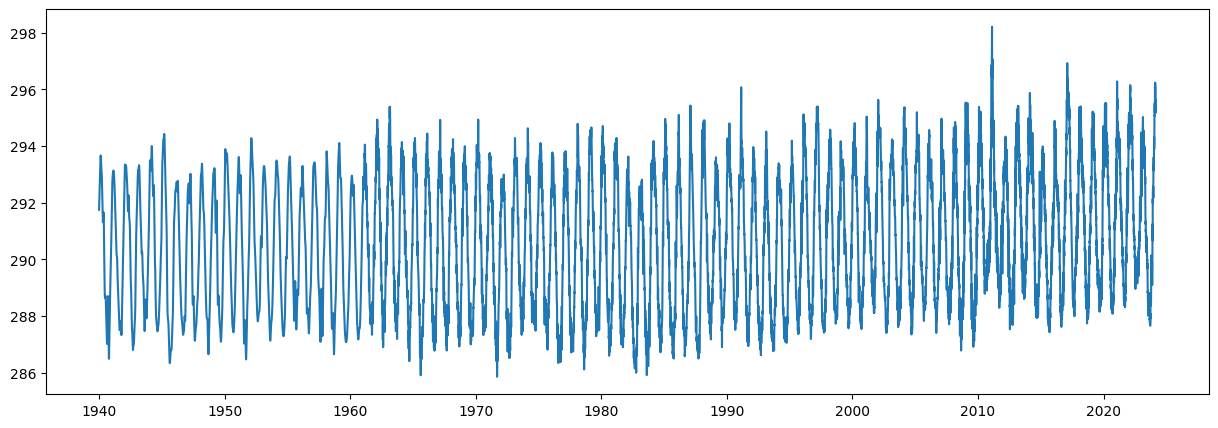

In [620]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 5))
ax.plot(south_pacific['time'], south_pacific['sst'])

The sea surface temperature is gradually increasing over the years in the South Pacific. That means there is a warming trend that I can extract.

### Prepare and normalize the data

Since we'll use linear regression and random forest regression to answer the additional analysis question, we have to split each dataset into a training set and a testing set and normalize each dataset.

Let's split the data into training and testing data.

In [621]:
south_pacific_train, south_pacific_test = train_test_split(south_pacific, test_size=.2, random_state=1)
north_pacific_train, north_pacific_test = train_test_split(north_pacific, test_size=.2, random_state=1)

Now we will split the predictors from the target for each dataset.

In [622]:
X_train_north_pacific = north_pacific_train.drop(columns=['sst', 'time'])
Y_train_north_pacific = north_pacific_train['sst']
X_test_north_pacific = north_pacific_test.drop(columns=['sst', 'time'])
Y_test_north_pacific = north_pacific_test['sst']

X_train_south_pacific = south_pacific_train.drop(columns=['sst', 'time'])
Y_train_south_pacific = south_pacific_train['sst']
X_test_south_pacific = south_pacific_test.drop(columns=['sst', 'time'])
Y_test_south_pacific = south_pacific_test['sst']

Find the mean and standard deviation of each training set.

In [623]:
train_mean_north_pacific = X_train_north_pacific.mean()
train_mean_north_pacific

wind_speed     1.476208
wave_height    2.625496
dtype: float64

In [624]:
train_sd_north_pacific = X_train_north_pacific.std()
train_sd_north_pacific

wind_speed     6.041848
wave_height    1.310938
dtype: float64

In [625]:
train_mean_south_pacific = X_train_south_pacific.mean()
train_sd_south_pacific = X_train_south_pacific.std()

We normalize the data here.

In [626]:
X_train_north_pacific = (X_train_north_pacific - train_mean_north_pacific)/train_sd_north_pacific
X_train_north_pacific.head()

,wind_speed,wave_height
1863,3.001132,1.953995
6938,-0.121532,0.822096
18161,0.172370,-0.212896
9568,0.086654,0.483804
11066,-1.772746,0.049926


In [627]:
X_train_south_pacific = (X_train_south_pacific - train_mean_south_pacific)/train_sd_south_pacific
X_train_south_pacific.head()

,wind_speed,wave_height
1863,-1.671904,-0.227570
6938,-0.764640,-1.297696
18161,0.911364,-0.439840
9568,1.837976,1.426732
11066,0.732973,0.579232


## Time series filtering: Moving average

I'll use the SST to extract the warming trend from the South Pacific Ocean data. I'll plot the 10-year moving average of the SST to extract the trend.

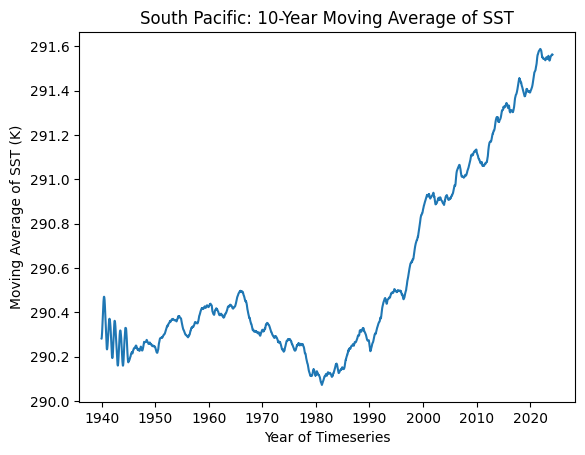

In [628]:
fig, ax = plt.subplots()

sst = south_pacific['sst'].values
time = south_pacific['time'].values

window_len = 365*10 # 10-year window length
ma_south_pacific = uniform_filter1d(sst, size=window_len)

ax.plot(time, ma_south_pacific)
ax.set_title("South Pacific: 10-Year Moving Average of SST")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Moving Average of SST (K)")
plt.show()

The SST in the South Pacific Ocean has been drastically increasing between the 1980s and now. While there are small fluctuations in the moving average between the 1980s and now, the general trend is that the SST is increasing. So, the South Pacific Ocean shows a clear warming trend.

## Forecasting

Now I will use lagged autoregression to forecast the warming trend into the future. I'll use a lag of 10 years so that I can predict the SST in the South Pacific Ocean 10 years into the future.

Since the SST is increasing so rapidly, I'll keep most of the data as training data so that the forecast is based on recent data. The training data will be all the data except for the last 13 years.

In the following two cells, we'll fit the model and then plot the observed and predicted SST. We'll also calculate the root mean squared error (RMSE) to evaluate how well the model fits the data.

In [629]:
k = 365*10 # 10-year lag

ma_south_pacific = ma_south_pacific.reshape(-1, 1)

train_end =  int(len(ma_south_pacific)-k-365*3) # The index where the training data ends
train_indices = list(range(train_end))          # indices of the training data
test_indices = list(range(train_end+1, len(ma_south_pacific))) # indices of the test data

ma_train = ma_south_pacific[train_indices, :]
ma_test = ma_south_pacific[test_indices, :]

ma_predictor_train = ma_train[:-k, :]
ma_predictor_test = ma_test
ma_response_train = ma_train[k:, :]
ma_response_test = ma_test[k:, :]

reg = LinearRegression().fit(ma_predictor_train, ma_response_train)
ma_predicted = reg.predict(ma_predictor_test)

# The predicted time will be up to 2034, so we need to make a time vector for that to plot the predicted SST over time
predicted_time = pd.date_range(start=pd.to_datetime(south_pacific['time'][test_indices[k]]), \
                               end=pd.to_datetime(south_pacific['time'][test_indices[-1]]) + pd.DateOffset(years=k/365))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((ma_predicted[:len(ma_response_test)] - ma_response_test)**2))

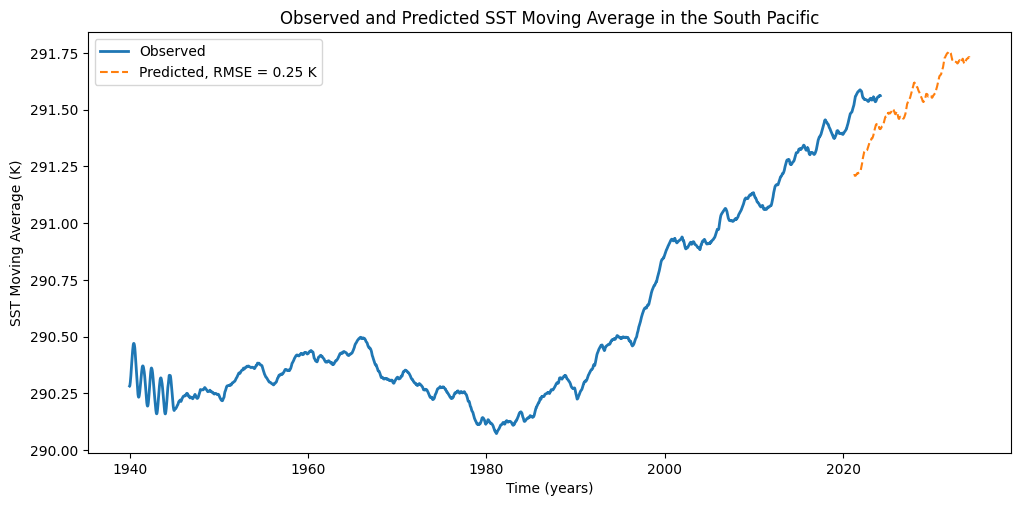

In [630]:
# Plotting
fig, ax = plt.subplots()
ax.set_xlabel("Time (years)")
ax.set_ylabel("SST Moving Average (K)")
ax.set_title("Observed and Predicted SST Moving Average in the South Pacific")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
ax.plot(time, ma_south_pacific, '-', linewidth=2, label="Observed")
ax.plot(predicted_time[:-2], ma_predicted, '--', label=f"Predicted, RMSE = {rmse:.2f} K")

ax.legend()
plt.show()

According to the forecast, the sea surface temperature will continue to increase 10 years in the future. There are some slight fluctuations in the future SST prediction, but the general trend is increasing. This is an accurate forecast since the RMSE is only 0.25 K, which is small compared to the range of the SST moving average (about 1.5 K). The implications are that, based on the rate of global warming in the past, global warming will continue in the future.

## Additional Question

In the North Pacific and South Pacific ocean basins, what is the relationship between sea surface temperature and wave height? What is the relationship between sea surface temperature and wind speed?




### Exploratory data analysis

We will make one correlation matrix for the North Pacific ocean data and one for the South Pacific ocean data. This way, we'll see how strong the linear relationship is between the predictors and SST in each ocean.

In [631]:
# Plot a correlation matrix of the variables in a DataFrame (df)
# ocean_name: the name of the ocean that the DataFrame contains the data for
def plot_correlation_matrix(df, ocean_name):
  corr_matrix = df.corr()
  plt.figure(figsize=(5,5))
  sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')
  plt.title("Correlation matrix for "+ocean_name)
  plt.tick_params(labelsize=12);

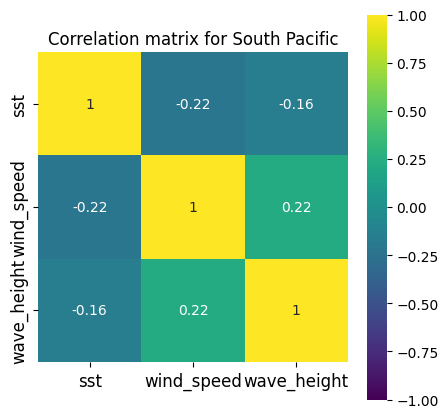

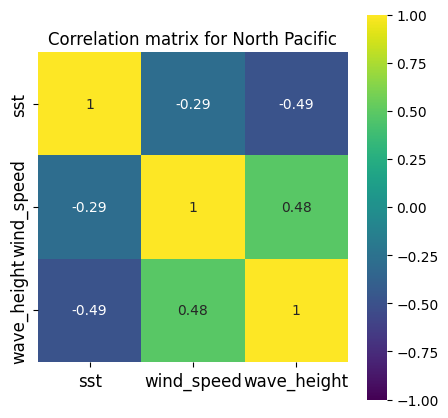

In [632]:
for pair in zip((south_pacific, north_pacific), \
               ("South Pacific", "North Pacific")):
  plot_correlation_matrix(pair[0][['sst', 'wind_speed', 'wave_height']], pair[1])

There is a weak negative linear relationship between SST and wave height in the South Pacific. This is because the corresponding correlation coefficient is negative. There is also a weak negative linear relationship between SST and wind speed, but that one is slightly stronger.

In the North Pacific, there is a stronger linear relationship between wave height and SST, since that correlation coefficient is -0.49. That is also a negative relationship. There is a weak relationship between wind speed and SST in the North Pacific (the correlation coefficient is -0.29).

In the North Pacific, wind speed and wave height are more correlated with SST than in the South Pacific. In both oceans, as the wind speed and wave height increase, the SST tends to decrease.

### Linear regression

To answer the additional analysis question, we will do linear regression with wind and wave height as the predictors and SST as the target, for each ocean basin.

In [633]:
"""
This function calculates the root mean square error and plots the results for a regression problem.
"""
def plot_regression_results(Y_train, Y_test, Y_pred_train, Y_pred_test, ocean_name):
  one_train = np.linspace(Y_train.min(), Y_train.max(), 100)
  one_test = np.linspace(Y_test.min(), Y_test.max(), 100)
  rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
  rmse_train = np.sqrt(np.mean((Y_pred_train - Y_train)**2))

  fig,(ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(Y_pred_train, Y_train, 'o')
  ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} K")
  ax1.set_title(ocean_name + " Training Set")
  ax1.set_xlabel(ocean_name + " Predicted Sea Surface Temperature")
  ax1.set_ylabel(ocean_name + " Actual Sea Surface Temperature")
  ax1.legend()

  ax2.plot(Y_pred_test, Y_test, 'o')
  ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} K")
  ax2.legend()
  ax2.set_title(ocean_name + " Test Set")
  ax2.set_xlabel("Predicted Sea Surface Temperature")
  ax2.set_ylabel("Actual Sea Surface Temperature")
  fig.set_size_inches(12, 5)

Let's fit the model and do a prediction. Then, we'll evaluate how well the model fits the data.

In [634]:
lin_reg_north_pacific = LinearRegression().fit(X_train_north_pacific, Y_train_north_pacific)
Y_pred_test_north_pacific = lin_reg_north_pacific.predict(X_test_north_pacific)
Y_pred_train_north_pacific = lin_reg_north_pacific.predict(X_train_north_pacific)

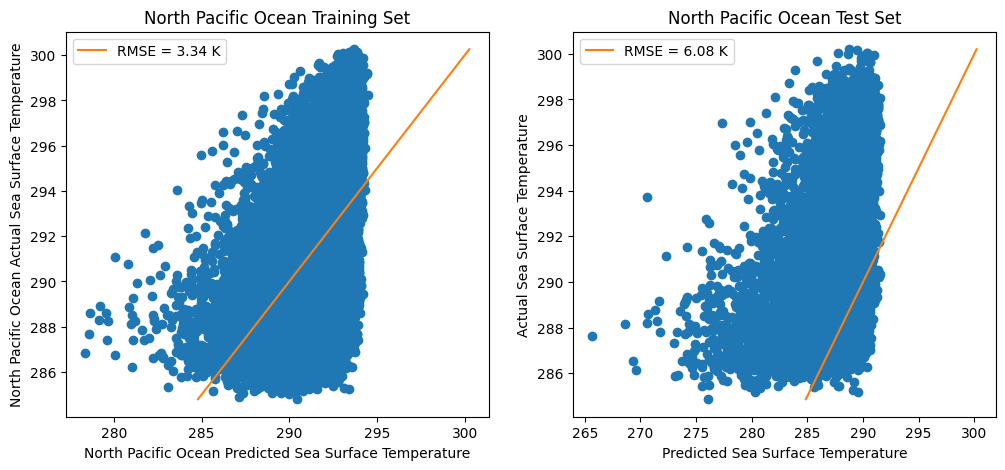

In [635]:
plot_regression_results(Y_train_north_pacific, Y_test_north_pacific, Y_pred_train_north_pacific, Y_pred_test_north_pacific, "North Pacific Ocean")

In [636]:
print(Y_test_north_pacific.max() - Y_test_north_pacific.min())

15.341319999999996


The RMSE of the test set for the North Pacific Ocean is 6.08 K. The range of the SST values for the North Pacific ocean is about 15.3 K. So, the RMSE is fairly low compared to the scale of the data. So, the model fits the data fairly well.

Now let's look at the coefficients of the linear regression problem.

In [637]:
coefficients_df = pd.DataFrame(data=lin_reg_north_pacific.coef_.reshape((1,2)), columns=X_train_north_pacific.columns)
coefficients_df

,wind_speed,wave_height
0,-0.282489,-1.728746


Each coefficient can be interpreted as the change in the target due to a one-unit increase in the corresponding predictor.

`wave_height`'s coefficient has a much larger magnitude than the coefficient of `wind_speed`. That means that, in the North Pacific, wave height is far more important for predicting SST than wind speed, and there is a strong relationship between wave height and SST.

Specifically, when the wave height increases by 1 m, the SST decreases by about 1.73 K. So, on days with higher waves, the SST tends to be lower in the North Pacific.

The relationship between SST and wind is not as strong. When the wind speed increases by 1 m, the SST decreases by .28 K. So, on days with higher waves, there tends to be less wind, but the relationship is weak.


Let's do the same linear regression for the South Pacific.

In [638]:
lin_reg_south_pacific = LinearRegression().fit(X_train_south_pacific, Y_train_south_pacific)
Y_pred_test_south_pacific = lin_reg_south_pacific.predict(X_test_south_pacific)
Y_pred_train_south_pacific = lin_reg_south_pacific.predict(X_train_south_pacific)

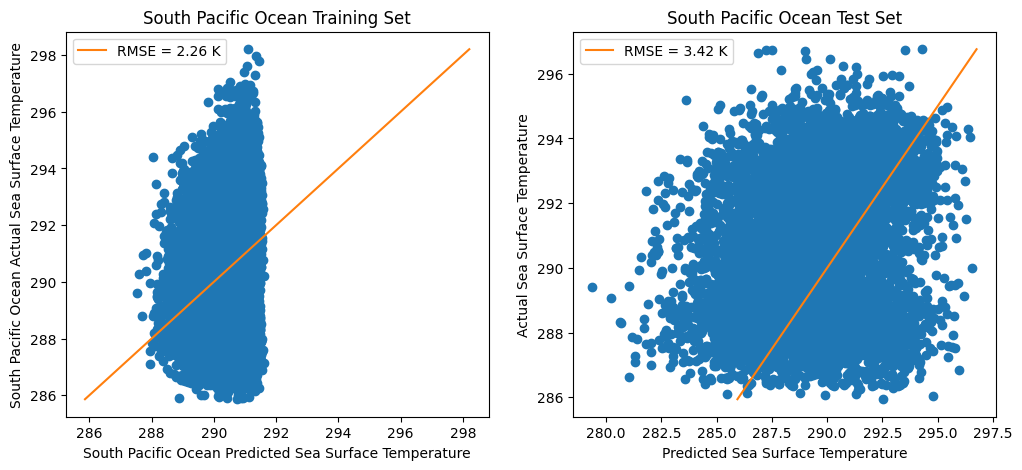

In [639]:
plot_regression_results(Y_train_south_pacific, Y_test_south_pacific, Y_pred_train_south_pacific, Y_pred_test_south_pacific, "South Pacific Ocean")

The RMSE is low, so the linear model fits the South Pacific data well.

In [640]:
coefficients_df = pd.DataFrame(data=lin_reg_south_pacific.coef_.reshape((1,2)), columns=X_train_south_pacific.columns)
coefficients_df

,wind_speed,wave_height
0,-0.441333,-0.289282


In the South Pacific, as the wind speed increases by 1 m/s, the SST decreases by .44 K. As the wave height increases by 1 m, the SST decreases by .29 K. So, in the South Pacific, wind has a slightly stronger relationship with SST than wave height. In the North Pacific, wave height has a much stronger relationship with SST, though. To further confirm that, let's run a random forest regressor on each dataset and look at the feature importances.

### Random forest

Let's do a parameter sweep for each dataset. The parameters we'll tune are `n_estimators` and `min_samples_split`.

In [641]:
"""
Perform a parameter sweep for a random forest with the given training and test sets.
The parameters being tuned are n_estimators and min_samples_split
"""
def random_forest_parameter_sweep(X_train, Y_train, X_test, Y_test):
  # Defining our search space
  n_estimator_values = [8, 16, 32, 64, 128]
  min_samples_split_values = [2, 4, 8, 16]

  out = {} # output dictionary

  # Training a model for each combination of n_estimators and min_samples_split
  for n_estimators in n_estimator_values:
    for min_samples_split in min_samples_split_values:
      rf_reg = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=0).fit(X_train, Y_train)
      Y_pred_test = rf_reg.predict(X_test)
      rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
      out[(n_estimators, min_samples_split)] = rmse_test

  sorted_out = dict(sorted(out.items(), key=lambda item: item[1])) # Sort the dictionary by RMSE

  for key, val in sorted_out.items():
    print(f"{key[0]} trees, {key[1]} min samples: rmse = {val}")

In [ ]:
random_forest_parameter_sweep(X_train_south_pacific, Y_train_south_pacific, X_test_south_pacific, Y_test_south_pacific)

In [ ]:
random_forest_parameter_sweep(X_train_north_pacific, Y_train_north_pacific, X_test_north_pacific, Y_test_north_pacific)

For the South Pacific data, the best parameter values are `n_estimators=128` and `min_samples_split=16`. For the North Pacific data, the best ones are `n_estimators=8` and `min_samples_split=16`.

Now we will fit the model and analyze the model results.

In [ ]:
rf_reg_north_pacific = RandomForestRegressor(random_state=0, bootstrap=True, n_estimators=8, min_samples_split=16).fit(X_train_north_pacific, Y_train_north_pacific)
Y_pred_test_north_pacific = rf_reg_north_pacific.predict(X_test_north_pacific)
Y_pred_train_north_pacific = rf_reg_north_pacific.predict(X_train_north_pacific)

rf_reg_south_pacific = RandomForestRegressor(random_state=0, bootstrap=True, n_estimators=128, min_samples_split=16).fit(X_train_south_pacific, Y_train_south_pacific)
Y_pred_test_south_pacific = rf_reg_north_pacific.predict(X_test_north_pacific)
Y_pred_train_south_pacific = rf_reg_north_pacific.predict(X_train_north_pacific)

In [ ]:
plot_regression_results(Y_train_north_pacific, Y_test_north_pacific, Y_pred_train_north_pacific, Y_pred_test_north_pacific, "North Pacific Ocean")

In [ ]:
plot_regression_results(Y_train_south_pacific, Y_test_south_pacific, Y_pred_train_south_pacific, Y_pred_test_south_pacific, "South Pacific Ocean")

In [ ]:
print("North Pacific SST range:", max(Y_test_north_pacific) - min(Y_test_north_pacific), "South Pacific SST range:", max(Y_test_south_pacific) - min(Y_test_south_pacific))

Again, for both ocean basins, the RMSE is fairly low compared to the range of the SST variable. So, the model fits the data well. Now we'll look at the feature importances to see whether wave height or wind is more important for predicting SST.

In [ ]:
feature_importances = rf_reg_north_pacific.feature_importances_
feature_importances_df = pd.DataFrame(data=feature_importances.reshape((1, 2)), columns=X_train_north_pacific.columns)
feature_importances_df

In the North Pacific Ocean, the feature importances indicate that wave height is much more important than wind for predicting SST. That matches the conclusions from our linear regression model.

In [ ]:
feature_importances = rf_reg_south_pacific.feature_importances_
feature_importances_df = pd.DataFrame(data=feature_importances.reshape((1, 2)), columns=X_train_south_pacific.columns)
feature_importances_df

In the South Pacific, wind is more important than wave height for predicting SST, but only slightly. That also matches the conclusions from the linear model.

## Conclusions

The sea surface temperature in the South Pacific Ocean has been drastically increasing between the 1980s and now. Based on the forecast, the SST in the South Pacific Ocean will continue to increase between now and 2034. So, we should expect global warming to continue.In the North Pacific Ocean, there is a strong relationship between wave height and SST. There is a relationship between wind and SST too, but it's much weaker. Also, wave height is much more important than wind for predicting SST in the North Pacific. In the South Pacific Ocean, the relationship between SST and wind is slightly stronger than that between SST and wave height. Furthermore, the feature importances indicate that wind is more important than wave height for predicting SST, but only slightly. So, as global warming continues in the South Pacific Ocean in the next ten years, we expect there to be less wind, and we expect the waves to have a lower height.


